# Описание датасета

По заданию используется датасет Electric Power Consumption, скачанный с ресурса Kaggle, ссылка на который представлена в списке использованной литературы. Для начала необходимо проанализировать данный датасет. Датасет представляет собой временной ряд, содержащий данные о потреблении электроэнергии в трех зонах города Тетуан (Марокко) с интервалом в 10 минут. \
В датасете представлены различные признаки, каждые из которых в той или иной степени влияет на показатель потребления электроэнергии. Признаки – время (Datetime), температура (Temperature), влажность (Humidity), скорость ветра (WindSpeed), общий диффузный поток (GeneralDiffuseFlows), диффузные потоки (DiffuseFlows). Выделены признаки, которые могут иметь сильную значимость в предсказании и те, которые не особо значимы. \
Признак Datetime – один из важных признаков, так как энергопотребление подвержено суточным и сезонным колебаниям. Также из этого признака можно извлечь в отдельные столбцы (признаки) дату и время (каждая запись с разницей в 10 минут), что поможет улучшить обучение и работу модели. \
Признак Temperature так же не ставиться под сомнение, если говорить о его значимости. Так как в зависимости от времени года используются различные приборы (обогреватели, кондиционеры), которые по разному влияют на потребление энергии. \
Аналогично с признаком Humidity, данный показатель также влияет на использование различных приборов, для изменения влажности в помещениях, что потенциально влияет на потребление электроэнергии. \
Признак WindSpeed предположительно может косвенно оказывать влияние на потребление электроэнергии. Например, в зданиях с плохой теплоизоляцией, ветер может влиять на температуру в помещениях этого здания. Однако данный признак стоит проверить на тепловой карте корреляций, чтобы сделать точные вводы о нем. \
Описание признака GeneralDiffuseFlows больше подходит под природное геотермальное явление, а не метеорологический параметр, который может напрямую воздействовать на потребление электричества в домах. Скорее всего, этот параметр не влияет на потребление энергии, и его можно исключить из модели, как и DiffuseFlows. Однако также стоит предварительно проверить показатели на тепловой карте корреляций. \
Целевой переменной в данном случае будет являться столбец с суммой трех столбцов с показателями, отвечающий за три разные зоны города.


# Импорт библиотек и загрузка датасета

Импортируются библиотеки, загружается датасет.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from keras.optimizers import Adam
import seaborn as sns
from keras.metrics import MeanAbsoluteError
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

df = pd.read_csv("powerconsumption.csv")
df.head(5)

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


# Предобработка данных

Для вывода информации о данных используется метод .info().

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


В данном датасете все столбцы содержат 52 416 значений, пропущенных значений нет. Восемь столбцов датасета имеют числовой тип данных (float64), что вполне разумно. Столбец Datetime имеет тип данных object, что не является корректным типом, необходимо внести изменение типа данных для этого столбца. Датасет желательно отсортировать по столбцу Datetime, в целях избежания случая, что временной ряд не упорядочен по дате. Также необходимо проверить временные интервалы между соседними записями (должен быть интервал каждые 10 минут).

In [3]:
df['Datetime']=pd.to_datetime(df.Datetime)
df.sort_values(by='Datetime', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
time_diffs = df['Datetime'].diff()
distant = time_diffs.nunique() == 1
distant

True

Результат True говорит о том, что интервалы верно распределены, записи идут каждые 10 минут, что подтверждает тот факт, что в данном столбце не пропусков. \
Проверка на отсутствие пропусков.

In [4]:
df.isna().sum()

,0
Datetime,0
Temperature,0
Humidity,0
WindSpeed,0
GeneralDiffuseFlows,0
DiffuseFlows,0
PowerConsumption_Zone1,0
PowerConsumption_Zone2,0
PowerConsumption_Zone3,0


Пропусков нет. \
Используется функция .describe() для описания числовых признаков.

In [5]:
df.describe()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
count,52416,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,2017-07-01 23:55:00,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
min,2017-01-01 00:00:00,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,2017-04-01 23:57:30,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,2017-07-01 23:55:00,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,2017-09-30 23:52:30,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,2017-12-30 23:50:00,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360
std,NaN,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099


Минимальное значение даты – 2017-01-01 00:00:00, максимальное значение – 2017-12-30 23:50:00, данные охватывают почти весь 2017 год с частотой каждые 10 минут. Среднее значение даты – 2017-07-01 23:55:00, что соответствует середине года. Временной ряд полный.
Температура сильно варьируется в зависимости от времени года, средняя температура составляет 18.81°C минимальная 3,25 градусов Цельсия (зимой), максимальная 40.01 градусов (летом). Стандартное отклонение составляет 5,82 градусов Цельсия. Разная температура в разное время года может корректироваться в помещении различными электроприборами. Так зимой при трех градусах Цельсия, вероятно, включаются нагревательные электроприборы. А летом при 40 градусах Цельсия явно используются кондиционеры.
Средний показатель влажности (68,26%) может говорить о том, что могут применяться осушители воздуха, так как показатель большой.
Скорость ветра в среднем низкая, около 1,96 метров в секунду. \
Поиск явных дубликатов в данных с помощью метода duplicated() и функции .sum().

In [6]:
print(df.duplicated().sum())

0


Явные дубликаты не найдены. \
Строится матрица рассеивания для числовых столбцов с целью лучше понять и проанализировать датасет.

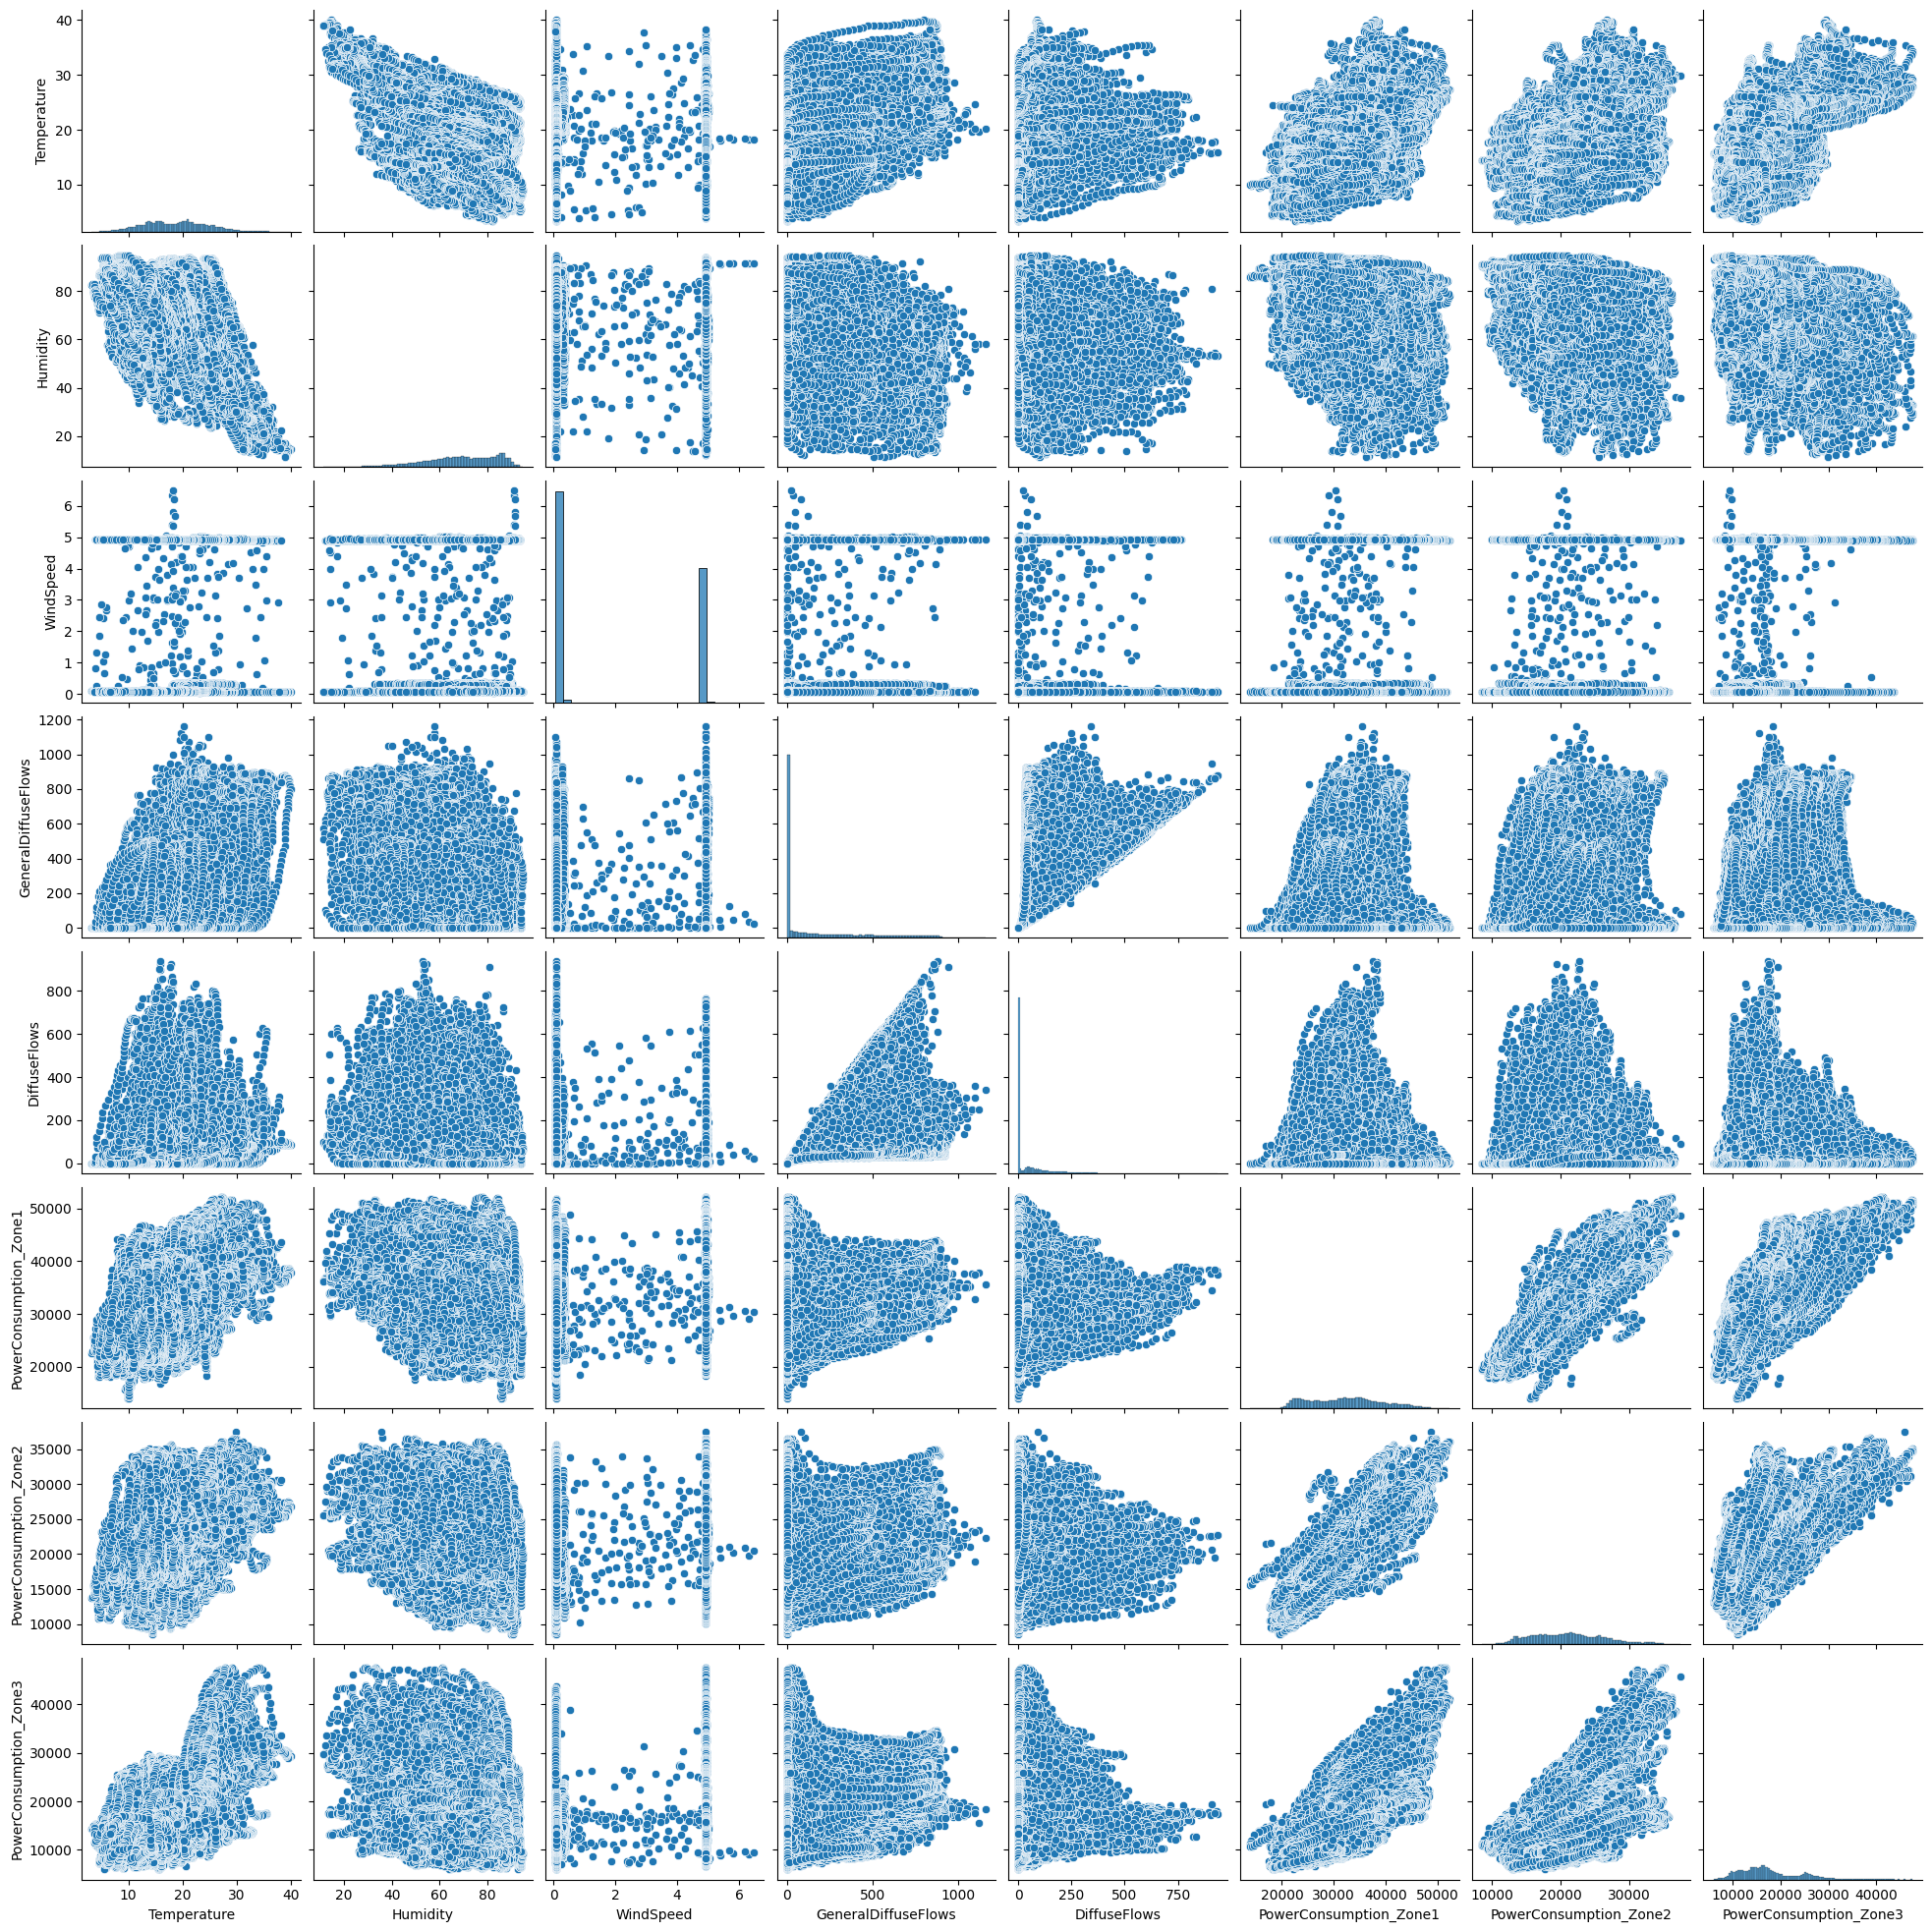

In [7]:
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
                 'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.show()

Из графика видно, нормальное распределение температуры и влажности. Данные скорости ветра распределены неравномерно, возможно, есть выбросы. Потребление энергии – плавное распределение, но с различными диапазонами по зонам. \
Видно, что при высокой температуре влажность падает, а при низкой – выше, что логично. Также есть зависимость между температурой и потреблением энергии – потребление выше в жаркую погоду, но не линейно, в тёплые месяцы может увеличиваться из-за кондиционеров. \
Для DiffuseFlows и GeneralDiffuseFlows есть чёткие кластеры данных. Возможно, чем сильнее потоки солнечной энергии, тем ниже потребление электроэнергии, например, используются солнечные батареи. \
Чтобы понять, являются ли  высокие значения ветра выбросами строится график распределения скорости ветра по дням.

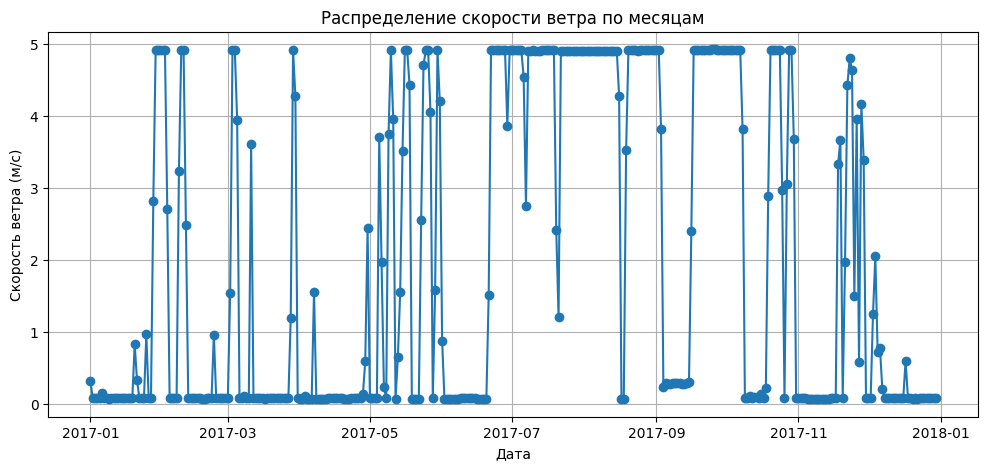

In [8]:
df_daily = df.resample('D', on='Datetime').mean()
plt.figure(figsize=(12, 5))
plt.plot(df_daily.index, df_daily['WindSpeed'], marker='o', linestyle='-')
plt.xlabel('Дата')
plt.ylabel('Скорость ветра (м/с)')
plt.title('Распределение скорости ветра по месяцам')
plt.grid()
plt.show()

Далее строится тепловая карта, чтобы лучше оценить зависимости между данными.

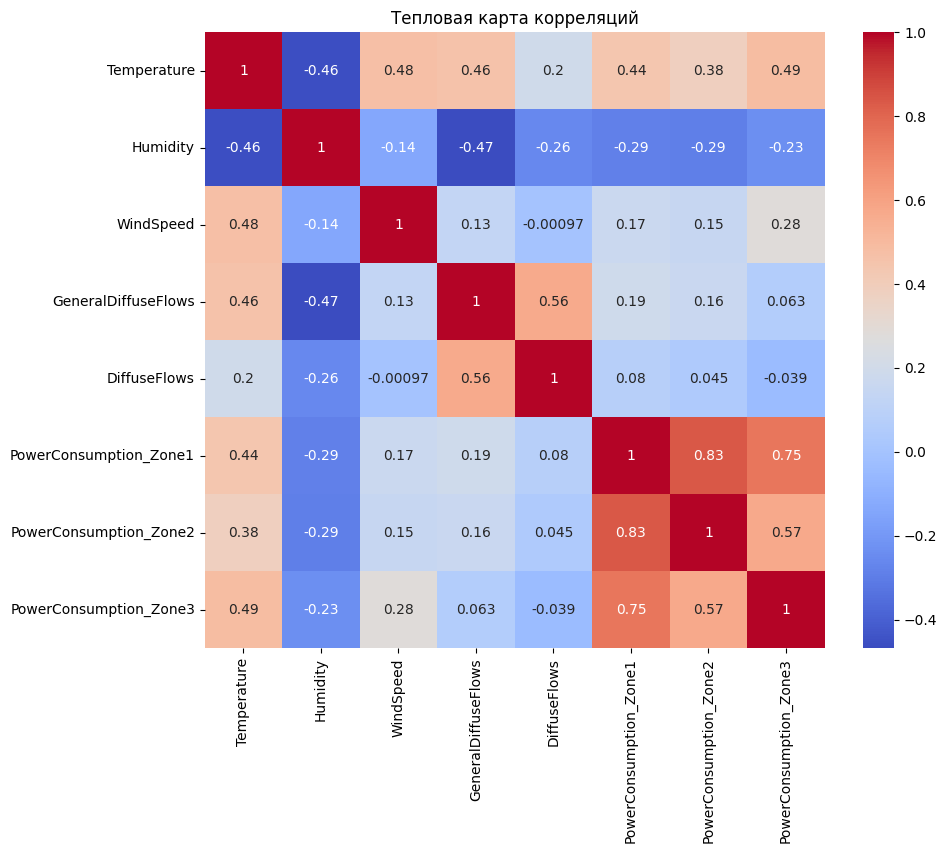

In [9]:
corr_matrix = df[['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Тепловая карта корреляций")
plt.show()

Коэффициенты корреляции между Temperature и всеми тремя зонами powerConsumption, равные 0,44 – для первой зоны, 0,38 – для второй зоны и 0,49 – для  третей зоны, говорят о средней по силе положительной корреляции, чем выше температура, тем больше потребляется энергии. \
Коэффициенты корреляции между Humidity и всеми тремя зонами powerConsumption, равные -0,29 – для первой зоны, -0,29 – для второй зоны и -0,23 – для  третей зоны, говорят о слабой отрицательной корреляции, чем ниже влажность, тем незначительно больше потребляется энергии. \
Коэффициенты корреляции между Humidity и всеми тремя зонами powerConsumption, равные -0,29 – для первой зоны, -0,29 – для второй зоны и -0,23 – для  третей зоны, говорят о слабой отрицательной корреляции, чем ниже влажность, тем незначительно больше потребляется энергии. \
Коэффициенты корреляции между Windspeed и всеми тремя зонами powerConsumption, равные 0,17 – для первой зоны, 0,15 – для второй зоны и 0,28 – для  третей зоны, говорят об очень слабой положительной корреляции. \
Коэффициенты корреляции между GeneralDiffuseFlows и всеми тремя зонами powerConsumption, равные 0,19 – для первой зоны, 0,16 – для второй зоны и 0,063 – для  третей зоны, говорят об очень слабой положительной корреляции, в третьем случае даже незначительная корреляция. \
Коэффициенты корреляции между DiffuseFlows и всеми тремя зонами powerConsumption, равные 0,08 – для первой зоны, 0,045 – для второй зоны и -0,039 – для  третей зоны, говорят об очень слабой и незначительной корреляции. Данный столбец можно не брать для обучения и предсказания следует удалить.

In [10]:
data = df.drop(columns=['DiffuseFlows'])
data

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,34055.69620,16128.87538,20240.96386
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,29814.68354,19375.07599,20131.08434
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,29128.10127,19006.68693,19668.43373
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,28228.86076,18361.09422,18899.27711
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,31160.45627,26857.31820,14780.31212
52412,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,30430.41825,26124.57809,14428.81152
52413,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,29590.87452,25277.69254,13806.48259
52414,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,28958.17490,24692.23688,13512.60504


Создается общий столбец SumPower с суммой измерений по 3 зонам, а 3 столбца удаляются.

In [11]:
data['SumPower'] = data['PowerConsumption_Zone1'] + data['PowerConsumption_Zone2'] + data['PowerConsumption_Zone3']
data = data.drop(columns=['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'])
data

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,SumPower
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,70425.53544
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,69320.84387
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,67803.22193
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,65489.23209
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,63650.44627
...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,72798.08659
52412,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,70983.80786
52413,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,68675.04965
52414,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,67163.01682


Из столбца Datatime вычленяются новые признаки – месяц, день недели, время суток. Для столбца с временем суток категории обозначаются числами, где 0 - ночь, 1 - утро, 2 - день, 3 - вечер.

In [12]:
data_new = data.copy()
data_new['Month'] = data_new['Datetime'].dt.month
data_new['DayOfWeek'] = data_new['Datetime'].dt.dayofweek

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 1
    elif 12 <= hour < 18:
        return 2
    elif 18 <= hour < 23:
        return 3
    else:
        return 4

data_new['TimeOfDay'] = data_new['Datetime'].dt.hour.apply(get_time_of_day)

data_new.set_index('Datetime', inplace=True)

data_new

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,SumPower,Month,DayOfWeek,TimeOfDay
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,70425.53544,1,6,4
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,69320.84387,1,6,4
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,67803.22193,1,6,4
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,65489.23209,1,6,4
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,63650.44627,1,6,4
...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,72798.08659,12,5,4
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,70983.80786,12,5,4
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,68675.04965,12,5,4


Добавляется шум к данным. Снова копируется датасет, в скопированном датасете выбираются столбцы, к которым будет добавлен шум (примерно 2% от среднего значения столбца).

In [13]:
data_noisy = data_new.copy()
cols = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows']
for col in cols:
    noise = np.random.normal(loc=0, scale=0.02 * data_noisy[col].mean(), size=len(data_noisy))
    data_noisy[col] += noise

data_noisy.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,SumPower,Month,DayOfWeek,TimeOfDay
Datetime,,,,,,,,
2017-01-01 00:00:00,6.902729,74.297001,0.144362,2.038899,70425.53544,1,6,4
2017-01-01 00:10:00,6.306520,75.569530,0.187908,-3.083185,69320.84387,1,6,4
2017-01-01 00:20:00,5.652337,75.598816,0.101006,6.625901,67803.22193,1,6,4
2017-01-01 00:30:00,6.273892,75.355871,0.108897,0.843135,65489.23209,1,6,4
2017-01-01 00:40:00,5.366015,75.420903,0.089324,4.606749,63650.44627,1,6,4


Далее нормализуются и кодируются признаки. Для числовых признакв, таких как Temperature, Humidity, WindSpeed, GeneralDiffuseFlows и SumPower используется MinMaxScaler. Для кодирования циклических признаков, таких как TimeOfDay, Month, DayOfWeek используется тригонометрическое кодирование. Тригонометрическое кодирование категориальных признаков в случае обучения модели LSTM будет более эффективно, так как сохраняет информацию о цикличности и уменьшает размерность данных по сравнению с OneHotEncoding, который создает кучу столбцов.

In [14]:
data_norm = data_noisy.copy()
numeric_features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows']
cyclic_features = ['TimeOfDay', 'Month', 'DayOfWeek']
target_column = 'SumPower'

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
data_norm[numeric_features] = scaler.fit_transform(data_norm[numeric_features])
data_norm[target_column] = scaler2.fit_transform(data_norm[[target_column]])

data_norm['TimeOfDay_sin'] = np.sin(2 * np.pi * data_norm['TimeOfDay'] / 4)
data_norm['TimeOfDay_cos'] = np.cos(2 * np.pi * data_norm['TimeOfDay'] / 4)

data_norm['Month_sin'] = np.sin(2 * np.pi * data_norm['Month'] / 12)
data_norm['Month_cos'] = np.cos(2 * np.pi * data_norm['Month'] / 12)

data_norm['DayOfWeek_sin'] = np.sin(2 * np.pi * data_norm['DayOfWeek'] / 7)
data_norm['DayOfWeek_cos'] = np.cos(2 * np.pi * data_norm['DayOfWeek'] / 7)

data_norm.drop(columns=['TimeOfDay', 'Month', 'DayOfWeek'], inplace=True)

data_norm.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,SumPower,TimeOfDay_sin,TimeOfDay_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
Datetime,,,,,,,,,,,
2017-01-01 00:00:00,0.105363,0.744193,0.035217,0.014151,0.345303,-2.449294e-16,1.0,0.5,0.866025,-0.781831,0.62349
2017-01-01 00:10:00,0.089351,0.758611,0.041821,0.009808,0.333964,-2.449294e-16,1.0,0.5,0.866025,-0.781831,0.62349
2017-01-01 00:20:00,0.071783,0.758943,0.028642,0.018041,0.318386,-2.449294e-16,1.0,0.5,0.866025,-0.781831,0.62349
2017-01-01 00:30:00,0.088475,0.756191,0.029839,0.013137,0.294634,-2.449294e-16,1.0,0.5,0.866025,-0.781831,0.62349
2017-01-01 00:40:00,0.064093,0.756927,0.026871,0.016328,0.275760,-2.449294e-16,1.0,0.5,0.866025,-0.781831,0.62349


Создается скользящее окно (размером 60). Выводится массив с признаками для каждого окна и массив с целевой переменной для каждого окна.

In [15]:
window_size = 60
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data.iloc[i:i + window_size].values
        X.append(window)
        y.append(data.iloc[i + window_size][target_column])

    return np.array(X), np.array(y)


X, y = create_sliding_window(data_norm, window_size)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (52356, 60, 11)
y shape: (52356,)


Таким образом X shape означает, что есть 52356 окон, каждый размером 60 временных шагов, и 11 признаков в каждом временном шаге, y shape – для каждого окна есть одно целевое значение (SumPower). \
Данные делятся на обучающую и тренировочную выборки.

In [16]:
split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (41884, 60, 11) (41884,)
Test shapes: (10472, 60, 11) (10472,)


Далее в y_test добавляются пропуски в размере 5%.

In [17]:
y_test_real = y_test.copy()
missing_percentage = 0.05
num_missing = int(len(y_test) * missing_percentage)

missing_indices = set()

while len(missing_indices) < num_missing:
    idx = np.random.randint(1, len(y_test) - 1)
    if idx - 1 not in missing_indices and idx + 1 not in missing_indices:
        missing_indices.add(idx)

missing_indices = list(missing_indices)
y_test[missing_indices] = np.nan

print("Пропуски в y:", np.isnan(y_test).sum(), "из", len(y_test))

Пропуски в y: 523 из 10472


# Обучение модели

Создается модель и компилируется. Первый LSTM слой должен как можно лучше захватывать временные зависимости, поэтому ему присваивается 100 нейронов. Также в первый слой добавляется параметр добавить параметр return_sequences=True, чтобы второй LSTM слой мог получать последовательность выходных данных (массив векторов) от первого. Также добавляется регуляризация Dropout(0.2), то есть 20% нейронов будут случайным образом отключаться, чтобы предотвратить переобучение. Учитывая, что задача восстановить пропущенные значения, то функция активации в выходном слое (Dense) будет линейной. Используется оптимизатор Adam, который хорошо подходит для многих нейросетей. Добавляется кастомная функция потерь masked_mse (на основе Mean Squared Error (MSE)). Предсказания модели на тестовых данных.

In [18]:
model = Sequential([
    Input(shape=(window_size, 11)),
    LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01)),
    LSTM(50),
    Dense(1, activation='linear')
])

def masked_mse(y_true, y_pred):
    mask = tf.cast(K.not_equal(y_true, 0), K.floatx())
    squared_error = K.square(y_true - y_pred)
    masked_squared_error = mask * squared_error
    return K.sum(masked_squared_error) / K.maximum(K.sum(mask), 1.0)

model.compile(optimizer='adam', loss=masked_mse, metrics=[MeanAbsoluteError(name='mae')])

y_test_missing = y_test.copy()
y_test_missing[missing_indices] = 0

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test_missing), verbose=1)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 102s 145ms/step - loss: 0.0596 - mae: 0.0496 - val_loss: 0.0025 - val_mae: 0.0447
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 136s 136ms/step - loss: 0.0021 - mae: 0.0287 - val_loss: 0.0016 - val_mae: 0.0371
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 145s 140ms/step - loss: 0.0014 - mae: 0.0233 - val_loss: 0.0013 - val_mae: 0.0380
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 91s 140ms/step - loss: 0.0011 - mae: 0.0202 - val_loss: 8.3412e-04 - val_mae: 0.0304
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 90s 138ms/step - loss: 9.6975e-04 - mae: 0.0190 - val_loss: 8.6860e-04 - val_mae: 0.0314
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 142s 138ms/step - loss: 8.1612e-04 - mae: 0.0169 - val_loss: 0.0017 - val_mae: 0.0463
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 138s 133ms/step - loss: 7.9117e-04 - mae: 0.0167 - val_loss: 0.0014 - val_mae: 0.0410
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 148s 143ms/step - loss: 6.4515e-04 - mae: 0.0148 - val_loss: 6.8632e-04 - val_mae: 0.032

# Оценка качества модели

Строится график потерь для обучения и тестирования.

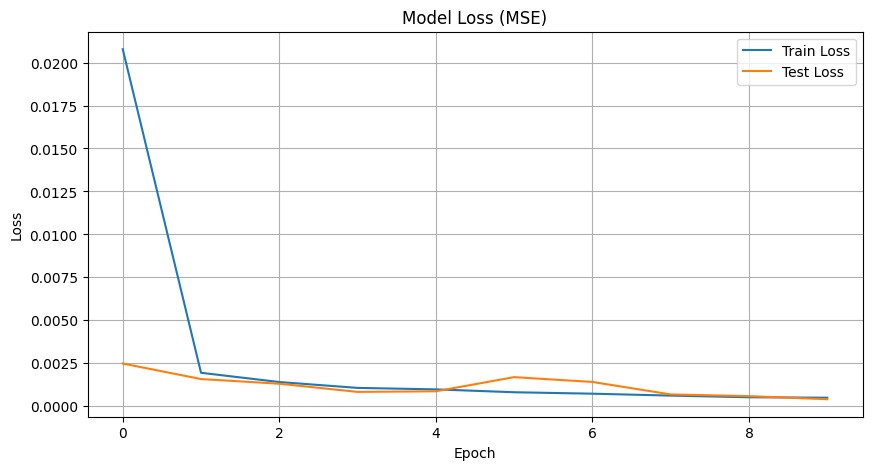

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

График выглядит достаточно хорошо. Падение на обучающей выборке говорит, что модель обучается и хорошо подстраивается под данные. Линия на тестовой выборке  тоже снижается и почти не расходится с линией обучающей, можно сделать вывод, что модель не переобучается. Разрыв между тестовой и обучающей выборкой небольшой -  модель обобщает данные и хорошо работает на тестовой выборке.\
Строится график изменения средней абсолютной ошибки для обучения и тестирования.

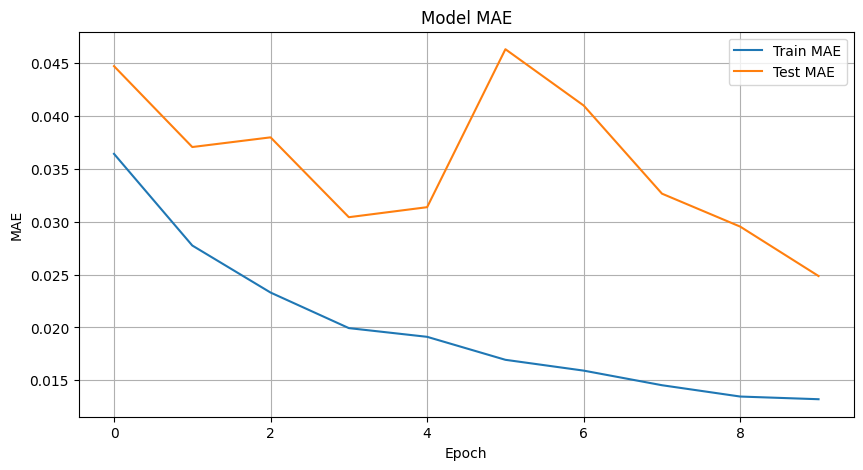

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Test MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

Линия обучения падает, значит, модель хорошо обучается. Тестовая ошибка падает медленнее и немного колеблется, что может говорить о недообучении или шуме в данных. Так как тест местами взлетает резко вверх, можно предположить, что имеет место быть небольшому переобучению. \
Выводятся метрики оценки качества модели MSE, MAE и R². Перед выводом необходимо получить предсказания модели на тестовых данных и вернуть данные в исходный масштаб.

In [21]:
y_pred = model.predict(X_test)
y_pred_denorm = scaler2.inverse_transform(y_pred.reshape(-1, 1))
y_test_denorm = scaler2.inverse_transform(y_test_real.reshape(-1, 1))
mse = mean_squared_error(y_test_denorm, y_pred_denorm)
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
r2 = r2_score(y_test_denorm, y_pred_denorm)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

328/328 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
MSE: 2204871.6211
MAE: 1108.8620
R²: 0.9889


Поскольку энергопотребление измеряется в тысячах единиц - десятках тысяч единиц MAE = 1108.86 означает, что модель в среднем ошибается примерно на 1108 единиц энергии. При больших значениях потребления энергии эта относительная ошибка считается маленькой и является хорошим результатом. \
R² = 0.9889 указывает на то, что модель объясняет 98.89% дисперсии данных. Это может говорить о том, что модель работает очень хорошо, либо о том, что модель переобучается. \
Значение MSE также с учетом масштаба данных выглядит приемлемо.

# Сравнение качества модели с линейной интерполяцией

Пропущенные значения заполняются с помощью линейной интерполяции. Выводятся метрики.

In [22]:
y_test2 = pd.Series(y_test.copy())
interpolated = y_test2.interpolate(method='linear').values
lin_mse = mean_squared_error(y_test_real, interpolated)
lin_mae = mean_absolute_error(y_test_real, interpolated)
lin_r2 = r2_score(y_test_real, interpolated)

print(f"MSE: {lin_mse:.4f}")
print(f"MAE: {lin_mae:.4f}")
print(f"R²: {lin_r2:.4f}")

MSE: 0.0000
MAE: 0.0001
R²: 1.0000


Результаты показывают исключительно высокую точность линейной интерполяции. Скорее всего, потому что пропуски находятся на почти линейных участках, изменения между соседними точками минимальны. В данной задаче энергопотребления это означает, что в  данных нет резких скачков в зонах пропусков. Линейная интерполяция работает как идеальный метод для таких плавных данных.